In [1]:
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from trainer import train_model
from pathlib import Path
import numpy as np
import argparse
import os
from PIL import Image
import torchvision.models as models
import torchvision.transforms.functional as TF

In [16]:
import pandas as pd

# Plotting Results

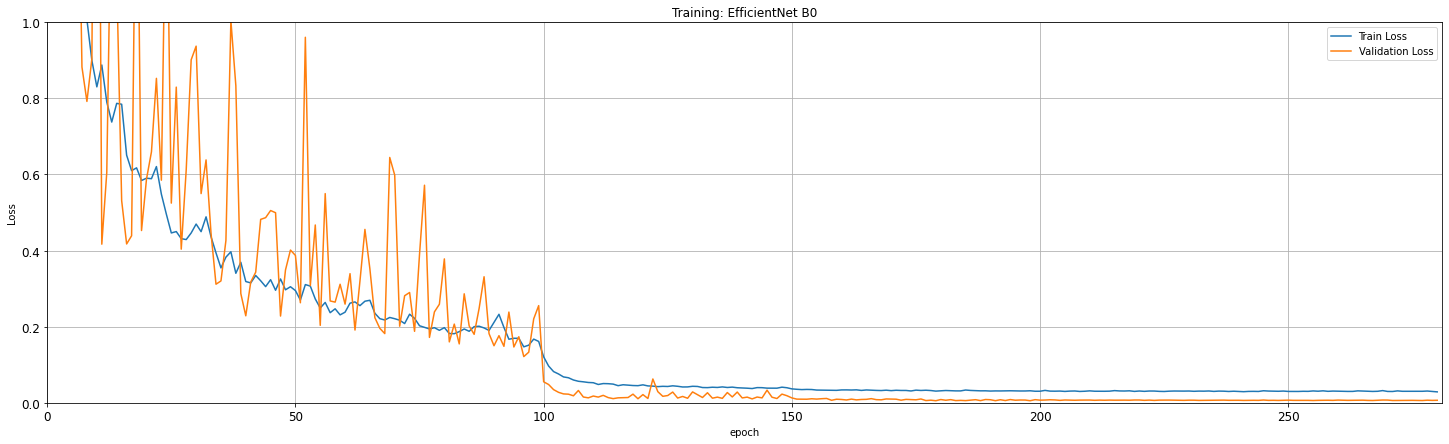

In [86]:
import matplotlib.pyplot as plt
adam_df = pd.read_csv("./results_adam/training_info.csv")
ax = adam_df[['train_loss', 'val_loss']].plot(title='Training: EfficientNet B0', figsize=(25, 7), fontsize=12, grid=True)
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.set_ylim([0, 1])
ax.set_xlim([0, len(adam_df)])
plt.legend(["Train Loss", "Validation Loss"], loc=0)

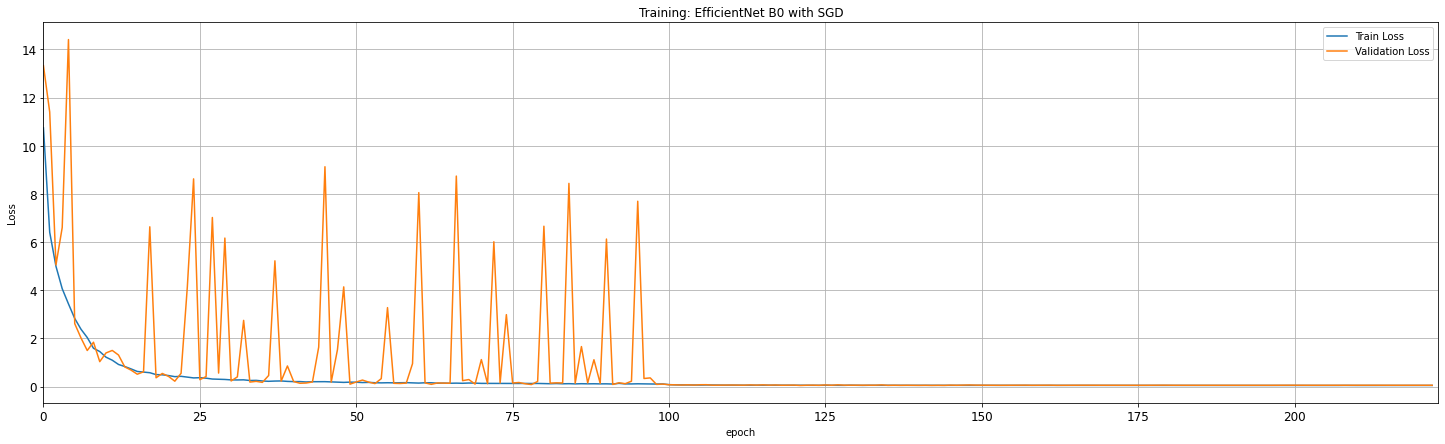

In [19]:
sgd_df = pd.read_csv("./results_sgd/training_info.csv")
ax = sgd_df[['train_loss', 'val_loss']].plot(title='Training: EfficientNet B0 with SGD', figsize=(25, 7), fontsize=12, grid=True)
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
# ax.set_ylim([0, 1])
ax.set_xlim([0, len(sgd_df)])
plt.legend(["Train Loss", "Validation Loss"], loc=0)

In [22]:
import time
def get_training_time(df):
    total_time = df.train_time.sum() + df.val_time.sum()
    ty_res = time.gmtime(total_time)
    return time.strftime("%H:%M:%S",ty_res)
print("Total Training Time SGD:", get_training_time(sgd_df))
print("Total Training Time Adam:", get_training_time(adam_df))

Total Training Time SGD: 13:46:03
Total Training Time Adam: 17:23:46


# Plotting the speed in the training video

In [13]:
train_labels = open("./data/train.txt", "r").readlines()
test_labels = open("./data/test.txt", "r").readlines()
train_labels = [float(l.replace('\n', '')) for l in train_labels]
test_labels = [float(l.replace('\n', '')) for l in test_labels]

In [ ]:
for x in range(0, len(train_labels)):
    plt.figure(x)
    plt.plot([i for i in range(len(train_labels))], train_labels)
    plt.scatter(x=x, y=train_labels[x], color='r')
    plt.xlabel("frames")
    plt.ylabel("speed")
    plt.savefig(f"./regular_frames/plot/{x:05}")

Text(0, 0.5, 'speed')

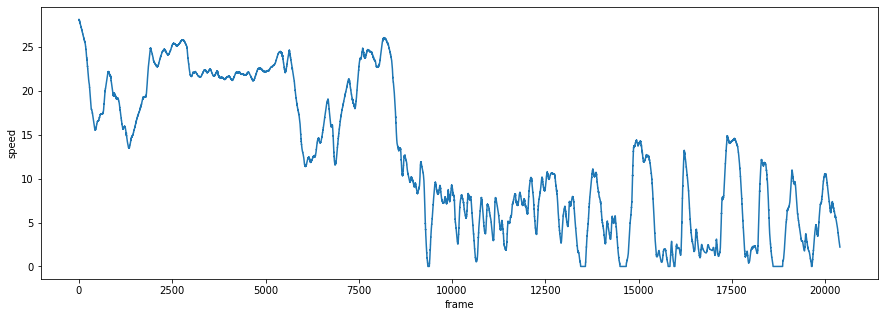

In [68]:
t = train_labels
plt.figure(figsize=(15, 5))
plt.plot([i for i in range(len(t))], t)
plt.xlabel("frame")
plt.ylabel("speed")

# Inference

In the rest of this notebook, we simply experiment with inference and how to save this data

In [11]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
frame_path = "./regular_frames/train/"
of_path = "./dataset/train"
Hori = None
for i in range(0, 200):
    img1 = cv2.imread(os.path.join(frame_path, f"{i:05}.jpg"))
    img2 = cv2.imread(os.path.join(of_path, f"{i:05}.jpg"))
    # concatenate image Horizontally
    Hori = np.concatenate((img1, img2), axis=1)
    cv2.imwrite(f"./data/optical_flow/{i:05}.jpg", Hori)

In [ ]:
import torch
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms.functional as TF

model = EfficientNet.from_pretrained(f'efficientnet-b0', in_channels=3, num_classes=1)
model.load_state_dict(torch.load("./results_adam/models/efficientnet-b0_final.pth", map_location=torch.device('cpu')))
model.eval()

class OFDataset(Dataset):
    """Dataset for optical flow images"""
    def __init__(self, of_dir, label_f, transform=None):
        self.transform = transform
        self.len = len(list(Path(of_dir).glob('*.jpg')))
        self.of_dir = of_dir
        self.label_file = open(label_f).readlines()[1:]

    def __len__(self): 
        return self.len

    def __getitem__(self, idx):
        image = Image.open(Path(self.of_dir)/f'{idx:05}.jpg')
        of_tensor = TF.to_tensor(image)if not self.transform else self.transform(TF.to_tensor(image))
        label = float(self.label_file[idx].split()[0])
        return [of_tensor, torch.tensor((label, ))]

test_dataset = OFDataset(os.path.join("./dataset", "test"), os.path.join("./data", "test.txt"))
testloader = DataLoader(test_dataset, batch_size=5, shuffle=False)

plot_path = "./regular_frames/plot_train"
frames = 0
font = cv2.FONT_HERSHEY_SIMPLEX
for i, (samples, labels) in enumerate(testloader):
    predictions = model(samples)
    print(predictions, labels)
    for i, (f, l, pred) in enumerate(zip(samples, labels, predictions)):
        img1 = f.squeeze().detach().cpu().numpy()
        cv2.putText(img1, f'Ground Truth : {l.item()}', (50, 50), font, 1, (0, 255, 255), 2, cv2.LINE_4)
        cv2.putText(img1, f'Prediction : {pred.item()}', (50, 100), font, 1, (0, 255, 255), 2, cv2.LINE_4)
        img2 = cv2.imread(os.path.join(plot_path, f"{frames:05}.png"))
        # concatenate image Horizontally
        Hori = np.concatenate((img1, img2), axis=1)
        cv2.imwrite(f"./data/test/{i:05}.jpg", Hori)
        frames += 1
    frames += labels.numel()
    break